In [1]:
from silab.utils import pred_accuracy, split_pred_accuracy 
from silab.convarchs import simple_CNN, MLP, DANN, RDANN
from silab.TDDAdata import TDDA_loader
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io as sio
import os
import numpy as np
import pandas as pd
from torch.utils.data import *
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pylab
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)

In [3]:
PATH = 'L:/vibnet-hankooktire/TDDA_dataset/npy_data/'

## Data loading

In [4]:
tdda = TDDA_loader(PATH, split=0.5)

In [40]:
tdda = TDDA_loader(PATH, split=0.80, rpm_flag = True, rpm_labels = [500,600,700,800,900,1000])

In [ ]:
train, test = tdda.getDataLoader()

In [ ]:
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader()

### Simple CNN test

Baseline test: supervised training with labels from all domain available

In [7]:
train, test = tdda.getDataLoader(sz_sourceDomain=800)

Number of examples in train and test dataloaders: train = 2400, test = 2400.
Source, target domain data points in train dataloader: 782, 1618; test dataloader: 818, 1582.


In [8]:
exp = 0
hash_exp = {}

for exp in range(10):
    m = simple_CNN([1,3,6,12,24],[1584,4])
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.00, lr=0.001)
    for epoch in range(2):
        run_loss = 0
        count = 0 
        for i, data in enumerate(train):
            x, y, domain_label = data
            opt.zero_grad()       
            y_hat = m(x)
            loss = F.nll_loss(y_hat,y)
            # if sample comes from target and not source ignore the loss
            if domain_label == 0:
                count += 1
            loss.backward()
            opt.step()
            run_loss += loss.item()
            if i % 1000 == 0 and i != 0:
                print('Loss: {}'.format(run_loss/(i)))
                print('Train accuracy on source domain: {}'.format(pred_accuracy(m, train, len(train)), False,True))
                print('Train accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, train, len(train),True,False)))
                print('Test accuracy on source domain: {}'.format(pred_accuracy(m, test, len(test),False,True))) 
                print('Test accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, test, len(test),True,False)))
                print('Train accuracy on all: {}'.format(pred_accuracy(m, train, len(train),True,True))) 
                print('Test accuracy on all: {}'.format(pred_accuracy(m, test, len(test),True,True)))
    hash_exp[exp] = [pred_accuracy(m, train, len(train),True,False),pred_accuracy(m, test, len(test),True,False),pred_accuracy(m, test, len(test),True,True)]        

Loss: 0.40460141708701847
Train accuracy on source domain: 0.4936061381074169
Train accuracy on target domains (different rpm): 0.8250927070457355
Test accuracy on source domain: 0.49266503667481665
Test accuracy on target domains (different rpm): 0.8109987357774968
Train accuracy on all: 0.7170833333333333
Test accuracy on all: 0.7025
Loss: 0.3193569636982866
Train accuracy on source domain: 0.989769820971867
Train accuracy on target domains (different rpm): 0.9981458590852905
Test accuracy on source domain: 0.9828850855745721
Test accuracy on target domains (different rpm): 0.9981036662452591
Train accuracy on all: 0.9954166666666666
Test accuracy on all: 0.9929166666666667
Loss: 0.1069306210950017
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 1.0
Test accuracy on source domain: 0.9987775061124694
Test accuracy on target domains (different rpm): 0.9993678887484198
Train accuracy on all: 1.0
Test accuracy on all: 0.9991666666666666
Loss: 0.0702

Train accuracy on all: 0.4691666666666667
Test accuracy on all: 0.46625
Loss: 0.3925807218924165
Train accuracy on source domain: 0.7838874680306905
Train accuracy on target domains (different rpm): 0.9758961681087762
Test accuracy on source domain: 0.8080684596577017
Test accuracy on target domains (different rpm): 0.9627054361567636
Train accuracy on all: 0.9133333333333333
Test accuracy on all: 0.91
Loss: 0.13834858444333076
Train accuracy on source domain: 0.989769820971867
Train accuracy on target domains (different rpm): 0.9888751545117429
Test accuracy on source domain: 0.988997555012225
Test accuracy on target domains (different rpm): 0.9860935524652339
Train accuracy on all: 0.9891666666666666
Test accuracy on all: 0.9870833333333333
Loss: 0.1001252414137125
Train accuracy on source domain: 0.7570332480818415
Train accuracy on target domains (different rpm): 0.9864029666254636
Test accuracy on source domain: 0.7628361858190709
Test accuracy on target domains (different rpm): 0

In [11]:
print([hash_exp[i] for i in range(10)])

[[0.9820766378244746, 0.9747155499367889, 0.9770833333333333], [1.0, 0.9993678887484198, 0.9995833333333334], [1.0, 1.0, 1.0], [0.9993819530284301, 0.9962073324905183, 0.98875], [0.8794808405438813, 0.8710493046776233, 0.8604166666666667], [1.0, 0.9993678887484198, 0.9979166666666667], [1.0, 0.9993678887484198, 0.9991666666666666], [0.9944375772558715, 0.9873577749683944, 0.9904166666666666], [0.9981458590852905, 0.9993678887484198, 0.9979166666666667], [1.0, 0.9993678887484198, 0.99875]]


### DA CNN test (unsupervised)

### 2 domains

In [25]:
tdda = TDDA_loader(PATH, split=0.7)
train, test = tdda.getDataLoader(sz_sourceDomain=800)

Number of examples in train and test dataloaders: train = 1119, test = 481.
Source, target domain data points in train dataloader: 550, 569; test dataloader: 250, 231.


In [ ]:
exp = 0
hash_exp = {}

for exp in range(1):
    m = simple_CNN([1,3,6,12,24],[1584,4])
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.0015, lr=0.001)
    for epoch in range(2):
        run_loss = 0
        count = 0 
        for i, data in enumerate(train):
            x, y, domain_label = data
            opt.zero_grad()       
            y_hat = m(x)
            loss = F.nll_loss(y_hat,y)
            # if sample comes from target and not source ignore the loss
            if domain_label == 0:
                count += 1
            else:
                loss.backward()
                opt.step()
                run_loss += loss.item()
            if i % 10000 == 0 and i != 0:
                print('Loss: {}'.format(run_loss/(i-count)))
                print('Train accuracy on source domain: {}'.format(pred_accuracy(m, train, len(train)), False,True))
                print('Train accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, train, len(train),True,False)))
                print('Test accuracy on source domain: {}'.format(pred_accuracy(m, test, len(test),False,True))) 
                print('Test accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, test, len(test),True,False)))
                print('Train accuracy on all: {}'.format(pred_accuracy(m, train, len(train),True,True))) 
                print('Test accuracy on all: {}'.format(pred_accuracy(m, test, len(test),True,True)))
                
    hash_exp[exp] = [pred_accuracy(m, train, len(train),True,False),pred_accuracy(m, test, len(test),True,False),pred_accuracy(m, test, len(test),True,True)] 

In [8]:
print([hash_exp[i] for i in range(5)])

[[0.19491525423728814, 0.18292682926829268, 0.446875], [0.24364406779661016, 0.2530487804878049, 0.6078125], [0.2478813559322034, 0.2530487804878049, 0.6171875], [0.15466101694915255, 0.17378048780487804, 0.5765625], [0.2478813559322034, 0.25, 0.615625]]


### 3 domains

In [11]:
tdda = TDDA_loader(PATH, split=0.7)
train, test = tdda.getDataLoader(sz_sourceDomain=800)

Number of examples in train and test dataloaders: train = 1679, test = 721.
Source, target domain data points in train dataloader: 575, 1104; test dataloader: 225, 496.


In [12]:
exp = 0
hash_exp = {}

for exp in range(5):
    m = simple_CNN([1,3,6,12,24],[1584,4])
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.0015, lr=0.001)
    for epoch in range(2):
        run_loss = 0
        count = 0 
        for i, data in enumerate(train):
            x, y, domain_label = data
            opt.zero_grad()       
            y_hat = m(x)
            loss = F.nll_loss(y_hat,y)
            # if sample comes from target and not source ignore the loss
            if domain_label == 0:
                count += 1
            else:
                loss.backward()
                opt.step()
                run_loss += loss.item()
            if i % 10000 == 0 and i != 0:
                print('Loss: {}'.format(run_loss/(i-count)))
                print('Train accuracy on source domain: {}'.format(pred_accuracy(m, train, len(train)), False,True))
                print('Train accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, train, len(train),True,False)))
                print('Test accuracy on source domain: {}'.format(pred_accuracy(m, test, len(test),False,True))) 
                print('Test accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, test, len(test),True,False)))
                print('Train accuracy on all: {}'.format(pred_accuracy(m, train, len(train),True,True))) 
                print('Test accuracy on all: {}'.format(pred_accuracy(m, test, len(test),True,True)))
    
    hash_exp[exp] = [pred_accuracy(m, train, len(train),True,False),pred_accuracy(m, test, len(test),True,False),pred_accuracy(m, test, len(test),True,True)] 

In [13]:
print([hash_exp[i] for i in range(5)])

[[0.2346014492753623, 0.24798387096774194, 0.42718446601941745], [0.23097826086956522, 0.24596774193548387, 0.3883495145631068], [0.2418478260869565, 0.2540322580645161, 0.361997226074896], [0.23822463768115942, 0.24596774193548387, 0.4812760055478502], [0.19927536231884058, 0.21370967741935484, 0.4563106796116505]]


### 4 domains

In [16]:
tdda = TDDA_loader(PATH, split=0.7)
train, test = tdda.getDataLoader(sz_sourceDomain=800)

Number of examples in train and test dataloaders: train = 2239, test = 961.
Source, target domain data points in train dataloader: 564, 1675; test dataloader: 236, 725.


In [17]:
exp = 0
hash_exp = {}

for exp in range(5):
    m = simple_CNN([1,3,6,12,24],[1584,4])
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.0015, lr=0.001)
    for epoch in range(2):
        run_loss = 0
        count = 0 
        for i, data in enumerate(train):
            x, y, domain_label = data
            opt.zero_grad()       
            y_hat = m(x)
            loss = F.nll_loss(y_hat,y)
            # if sample comes from target and not source ignore the loss
            if domain_label == 0:
                count += 1
            else:
                loss.backward()
                opt.step()
                run_loss += loss.item()
            if i % 100000 == 0 and i != 0:
                print('Loss: {}'.format(run_loss/(i-count)))
                print('Train accuracy on source domain: {}'.format(pred_accuracy(m, train, len(train)), False,True))
                print('Train accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, train, len(train),True,False)))
                print('Test accuracy on source domain: {}'.format(pred_accuracy(m, test, len(test),False,True))) 
                print('Test accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, test, len(test),True,False)))
                print('Train accuracy on all: {}'.format(pred_accuracy(m, train, len(train),True,True))) 
                print('Test accuracy on all: {}'.format(pred_accuracy(m, test, len(test),True,True)))
    hash_exp[exp] = [pred_accuracy(m, train, len(train),True,False),pred_accuracy(m, test, len(test),True,False),pred_accuracy(m, test, len(test),True,True)] 

In [18]:
print([hash_exp[i] for i in range(5)])

[[0.2734328358208955, 0.23310344827586207, 0.4006243496357961], [0.2, 0.1820689655172414, 0.3267429760665973], [0.25671641791044775, 0.2317241379310345, 0.42039542143600417], [0.1582089552238806, 0.18482758620689654, 0.32049947970863685], [0.2573134328358209, 0.23310344827586207, 0.4068678459937565]]


### 5 domains

In [21]:
tdda = TDDA_loader(PATH, split=0.7)
train, test = tdda.getDataLoader(sz_sourceDomain=800)

Number of examples in train and test dataloaders: train = 2799, test = 1201.
Source, target domain data points in train dataloader: 561, 2238; test dataloader: 239, 962.


In [22]:
exp = 0
hash_exp = {}

for exp in range(5):
    m = simple_CNN([1,3,6,12,24],[1584,4])
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.0015, lr=0.001)
    for epoch in range(2):
        run_loss = 0
        count = 0 
        for i, data in enumerate(train):
            x, y, domain_label = data
            opt.zero_grad()       
            y_hat = m(x)
            loss = F.nll_loss(y_hat,y)
            # if sample comes from target and not source ignore the loss
            if domain_label == 0:
                count += 1
            else:
                loss.backward()
                opt.step()
                run_loss += loss.item()
            if i % 10000 == 0 and i != 0:
                print('Loss: {}'.format(run_loss/(i-count)))
                print('Train accuracy on source domain: {}'.format(pred_accuracy(m, train, len(train)), False,True))
                print('Train accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, train, len(train),True,False)))
                print('Test accuracy on source domain: {}'.format(pred_accuracy(m, test, len(test),False,True))) 
                print('Test accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, test, len(test),True,False)))
                print('Train accuracy on all: {}'.format(pred_accuracy(m, train, len(train),True,True))) 
                print('Test accuracy on all: {}'.format(pred_accuracy(m, test, len(test),True,True)))
    hash_exp[exp] = [pred_accuracy(m, train, len(train),True,False),pred_accuracy(m, test, len(test),True,False),pred_accuracy(m, test, len(test),True,True)] 
        

In [23]:
print([hash_exp[i] for i in range(5)])

[[0.2658623771224307, 0.2588357588357588, 0.39217318900915904], [0.26630920464700625, 0.2796257796257796, 0.2964196502914238], [0.2453083109919571, 0.25675675675675674, 0.4029975020815987], [0.24754244861483468, 0.26195426195426197, 0.3039134054954205], [0.24039320822162646, 0.2598752598752599, 0.3688592839300583]]


### 6 domains

In [27]:
tdda = TDDA_loader(PATH, split=0.7)
train, test = tdda.getDataLoader(sz_sourceDomain=800)

Number of examples in train and test dataloaders: train = 3359, test = 1441.
Source, target domain data points in train dataloader: 581, 2778; test dataloader: 219, 1222.


In [28]:
exp = 0
hash_exp = {}

for exp in range(5):
    m = simple_CNN([1,3,6,12,24],[1584,4])
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.0015, lr=0.001)
    for epoch in range(2):
        run_loss = 0
        count = 0 
        for i, data in enumerate(train):
            x, y, domain_label = data
            opt.zero_grad()       
            y_hat = m(x)
            loss = F.nll_loss(y_hat,y)
            # if sample comes from target and not source ignore the loss
            if domain_label == 0:
                count += 1
            else:
                loss.backward()
                opt.step()
                run_loss += loss.item()
            if i % 100000 == 0 and i != 0:
                print('Loss: {}'.format(run_loss/(i-count)))
                print('Train accuracy on source domain: {}'.format(pred_accuracy(m, train, len(train)), False,True))
                print('Train accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, train, len(train),True,False)))
                print('Test accuracy on source domain: {}'.format(pred_accuracy(m, test, len(test),False,True))) 
                print('Test accuracy on target domains (different rpm): {}'.format(pred_accuracy(m, test, len(test),True,False)))
                print('Train accuracy on all: {}'.format(pred_accuracy(m, train, len(train),True,True))) 
                print('Test accuracy on all: {}'.format(pred_accuracy(m, test, len(test),True,True)))
    hash_exp[exp] = [pred_accuracy(m, train, len(train),True,False),pred_accuracy(m, test, len(test),True,False),pred_accuracy(m, test, len(test),True,True)]

In [29]:
print([hash_exp[i] for i in range(5)])

[[0.24154067674586033, 0.22749590834697217, 0.29285218598195695], [0.24802015838732902, 0.23731587561374795, 0.24011103400416378], [0.2613390928725702, 0.23895253682487724, 0.24149895905621097], [0.2973362131029518, 0.2806873977086743, 0.2768910478834143], [0.2580993520518359, 0.2332242225859247, 0.2387231089521166]]


## DANN - 2 domains 

Experiment with two domains only: 500, 600

Observations: 
1. If latent vector is not big enough, training troubles!

In [97]:
tdda = TDDA_loader(PATH, split=0.1)
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800, batch_size=10000)

Number of examples in source domain train and test dataloaders: train = 1, test = 1.
Number of examples in target domain train and test dataloaders: train = 1, test = 1.


In [94]:
tdda = TDDA_loader(PATH, split=0.8)
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800, batch_size=1)

Number of examples in source domain train and test dataloaders: train = 640, test = 160.
Number of examples in target domain train and test dataloaders: train = 1280, test = 320.


In [96]:
exp = 0
for exp in range(1):
    m1 = simple_CNN([1,3,6,12,24,48],[])
    m2 = simple_CNN([1,3,6,12,24,48,96],[1152,4])
    m3 = simple_CNN([1,3],[2001,2])

    m = DANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.00015, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 3, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[1,1,1], max_iterations= 1101)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 0.0022368431091308594, domain loss (source): 0.6931356191635132, domain loss (target): 0.6931586861610413
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.29453125
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.278125
Experiment number: 0


In [81]:
for i,d in enumerate(srtrain):
    x,y = next(iter(srtrain))
    print(x.shape,y.shape)
    x,y = next(iter(srtest))
    print(x.shape,y.shape)
    x,y = next(iter(trtrain))
    print(x.shape,y.shape)
    x,y = next(iter(trtest))
    print(x.shape,y.shape)

torch.Size([480, 1201]) torch.Size([480])
torch.Size([320, 1201]) torch.Size([320])
torch.Size([960, 1201]) torch.Size([960])
torch.Size([640, 1201]) torch.Size([640])


In [98]:
for i,d in enumerate(trtest):
    x,y = next(iter(trtest))
    l,d,z = m(x,return_latent=True)

In [99]:
z = np.array(z.detach().numpy())

In [100]:
y = np.array(y.detach().numpy())

In [101]:
z.shape

(1440, 1344)

Text(0.5, 1.0, 'tSNE projection of RPM-500 dataset')

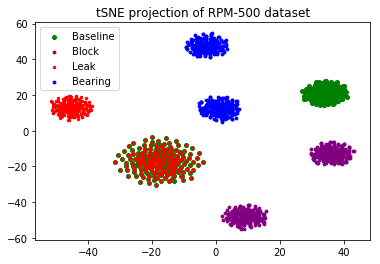

In [102]:
X = z
Y = TSNE(perplexity=30.0).fit_transform(X)

l=y
plt.scatter(Y[l==0, 0], Y[l==0, 1], s=16, color='green')
plt.scatter(Y[l==1, 0], Y[l==1, 1], s=8, color='purple')
plt.scatter(Y[l==2, 0], Y[l==2, 1], s=6, color='red')
plt.scatter(Y[l==3, 0], Y[l==3, 1], s=8, color='blue')
plt.legend(['Baseline','Block','Leak','Bearing'])
plt.title('tSNE projection of RPM-500 dataset')

### DANN - 3 domains

Experiment with 3 domains: 500, 600, 700

In [66]:
tdda = TDDA_loader(PATH, split=0.8)
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800)

Number of examples in source domain train and test dataloaders: train = 640, test = 160.
Number of examples in target domain train and test dataloaders: train = 1280, test = 320.


In [67]:
exp = 0
for exp in range(2):
    m1 = simple_CNN([1,3,6,12,24,48],[])
    m2 = simple_CNN([1,3,6,12,24,48,96],[1152,4])
    m3 = simple_CNN([1,3],[2001,2])

    m = DANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[10000], max_iterations= 1601)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 6.151199340820312e-05, domain loss (source): 0.6931471824645996, domain loss (target): 0.6931471824645996
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.19765625
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.178125
Experiment number: 0
Final results:
Label loss: 0.0009641647338867188, domain loss (source): 0.693406879901886, domain loss (target): 0.6931604743003845
Train accuracy on source domain: 0.99375
Train accuracy on target domains (different rpm): 0.23125
Test accuracy on source domain: 0.9875
Test accuracy on target domains (different rpm): 0.23125
Experiment number: 1


### DANN - 4 domains

Experiment with 4 domains: 500, 600, 700, 800. The latent feature space has to be expanded since we are trying to compress more information into it. Idea: map the decrease in performance as we move away from baseline domain to the difference between forcing frequency amplitidues?

In [63]:
tdda = TDDA_loader(PATH, split=0.7)
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800)

Number of examples in source domain train and test dataloaders: train = 559, test = 241.
Number of examples in target domain train and test dataloaders: train = 1679, test = 721.


In [64]:
exp = 0
for exp in range(5):
    m1 = simple_CNN([1,3,6,12,24,48],[])
    m2 = simple_CNN([1,3,6,12,24,48,96],[1152,4])
    m3 = simple_CNN([1,3],[2001,2])

    m = DANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[1], max_iterations= 2500)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 2.9067673683166504, domain loss (source): 0.36297115683555603, domain loss (target): 0.582761824131012
Train accuracy on source domain: 0.6493738819320215
Train accuracy on target domains (different rpm): 0.29839189994044074
Test accuracy on source domain: 0.6058091286307054
Test accuracy on target domains (different rpm): 0.29819694868238555
Experiment number: 0
Final results:
Label loss: 0.00025177001953125, domain loss (source): 0.6959279179573059, domain loss (target): 0.6939195394515991
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.3150684931506849
Test accuracy on source domain: 0.995850622406639
Test accuracy on target domains (different rpm): 0.3231622746185853
Experiment number: 1
Final results:
Label loss: 0.07817888259887695, domain loss (source): 0.7182165384292603, domain loss (target): 0.90850830078125
Train accuracy on source domain: 0.9821109123434705
Train accuracy on target domains (different rpm): 

### DANN - 5 domains

Experiment with 4 domains: 500, 600, 700, 800, 900.

In [77]:
tdda = TDDA_loader(PATH, split=0.7)
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800)

Number of examples in source domain train and test dataloaders: train = 559, test = 241.
Number of examples in target domain train and test dataloaders: train = 2239, test = 961.


In [78]:
exp = 0
for exp in range(5):
    m1 = simple_CNN([1,3,6,12,24,48],[])
    m2 = simple_CNN([1,3,6,12,24,48,96],[1152,4])
    m3 = simple_CNN([1,3],[2001,2])

    m = DANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[1], max_iterations= 2800)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 0.00030231475830078125, domain loss (source): 0.6934877038002014, domain loss (target): 0.6930975914001465
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.27288968289414917
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.2559833506763788
Experiment number: 0
Final results:
Label loss: 0.22077524662017822, domain loss (source): 0.4355592429637909, domain loss (target): 1.0348652601242065
Train accuracy on source domain: 0.9767441860465116
Train accuracy on target domains (different rpm): 0.15676641357748994
Test accuracy on source domain: 0.9626556016597511
Test accuracy on target domains (different rpm): 0.15400624349635797
Experiment number: 1
Final results:
Label loss: 0.05768704414367676, domain loss (source): 0.4539308249950409, domain loss (target): 0.4861099123954773
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.23805270209915141
Te

### DANN - 6 domains

Experiment with 4 domains: 500, 600, 700, 800, 900, 1000.

In [80]:
tdda = TDDA_loader(PATH, split=0.7)
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800)

Number of examples in source domain train and test dataloaders: train = 559, test = 241.
Number of examples in target domain train and test dataloaders: train = 2799, test = 1201.


In [81]:
exp = 0
for exp in range(5):
    m1 = simple_CNN([1,3,6,12,24,48],[])
    m2 = simple_CNN([1,3,6,12,24,48,96],[1152,4])
    m3 = simple_CNN([1,3],[2001,2])

    m = DANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[1], max_iterations= 3400)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 0.0006394386291503906, domain loss (source): 0.6952381134033203, domain loss (target): 0.6909305453300476
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.18863879957127547
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.18318068276436303
Experiment number: 0
Final results:
Label loss: 0.0001773834228515625, domain loss (source): 0.6935054063796997, domain loss (target): 0.6927692294120789
Train accuracy on source domain: 1.0
Train accuracy on target domains (different rpm): 0.18756698821007503
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.18151540383014156
Experiment number: 1
Final results:
Label loss: 1.7642974853515625e-05, domain loss (source): 0.6925541758537292, domain loss (target): 0.6937405467033386
Train accuracy on source domain: 0.9892665474060823
Train accuracy on target domains (different rpm): 0.26688102893890675
Test accurac

## RDANN 

In [5]:
tdda = TDDA_loader(PATH, split=0.70, rpm_flag = True, rpm_labels = [500,600])
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800)

500
600


IndexError: list index out of range

In [13]:
exp = 0
for exp in range(5):
    m1 = simple_CNN([1,3,6,12,24,48],[])
    m2 = simple_CNN([1,3,6,12,24,48],[1584,4])
    m3 = simple_CNN([1,3],[2001,1], smax_l=False)

    m = RDANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[1], dom_range = 100, max_iterations = 1101)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 0.0001926422119140625, domain loss (source): 1.9261479522469926e-08, domain loss (target): 0.9900001287460327
Train accuracy on source domain: 0.998211091234347
Train accuracy on target domains (different rpm): 0.2146690518783542
Test accuracy on source domain: 0.991701244813278
Test accuracy on target domains (different rpm): 0.16597510373443983
Experiment number: 0
Final results:
Label loss: 0.004977226257324219, domain loss (source): 0.00021846657909918576, domain loss (target): 0.9900000691413879
Train accuracy on source domain: 0.9874776386404294
Train accuracy on target domains (different rpm): 0.3595706618962433
Test accuracy on source domain: 0.970954356846473
Test accuracy on target domains (different rpm): 0.34854771784232363
Experiment number: 1
Final results:
Label loss: 0.011508941650390625, domain loss (source): 1.353555063587919e-07, domain loss (target): 0.9901300072669983
Train accuracy on source domain: 0.998211091234347
Train accuracy on ta

### RDANN - 3 domains

In [20]:
tdda = TDDA_loader(PATH, split=0.80, rpm_flag = True, rpm_labels = [500,600,700])
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800, batch_size=1)

Number of examples in source domain train and test dataloaders: train = 640, test = 160.
Number of examples in target domain train and test dataloaders: train = 1280, test = 320.


In [21]:
exp = 1
for exp in range(1):
    m1 = simple_CNN([1,12,48,96],[],ks=100)
    m2 = simple_CNN([1,3,6,12,24,48],[8640,4])
    m3 = simple_CNN([1,3],[9057,1], smax_l=False)

    m = RDANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[10000], dom_range = 200, max_iterations = 1601)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 0.002143383026123047, domain loss (source): 0.004999999888241291, domain loss (target): 0.9950000047683716
Train accuracy on source domain: 0.7390625
Train accuracy on target domains (different rpm): 0.25703125
Test accuracy on source domain: 0.7875
Test accuracy on target domains (different rpm): 0.240625
Experiment number: 0


In [8]:
for i,d in enumerate(trtest):
    x,y,td = next(iter(trtest))

In [60]:
for i,d in enumerate(trtest):
    x,y,td = next(iter(trtest))
    l,d,z = m(x,return_latent=True)

In [61]:
z = np.array(z.detach().numpy())

In [62]:
td = np.array(td.detach().numpy())

In [63]:
y = np.array(y.detach().numpy())

Text(0.5, 1.0, 'tSNE projection of RPM-500 dataset')

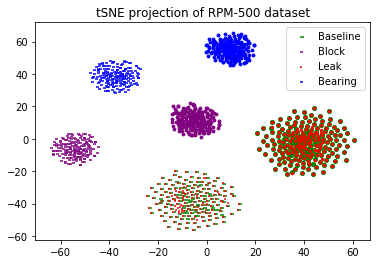

In [64]:
z.shape

X = z
Y = TSNE(perplexity=30.0).fit_transform(X)
l=y

Y1 = Y[td==500]
Y2 = Y[td==600]
Y3 = Y[td==700]
l2 = l[td==600]
l3 = l[td==700]


plt.scatter(Y2[l2==0, 0], Y2[l2==0, 1], s=16, marker=1, color='green')
plt.scatter(Y2[l2==1, 0], Y2[l2==1, 1], s=8, marker=1, color='purple')
plt.scatter(Y2[l2==2, 0], Y2[l2==2, 1], s=6, marker=1, color='red')
plt.scatter(Y2[l2==3, 0], Y2[l2==3, 1], s=8, marker=1, color='blue')
plt.scatter(Y3[l3==0, 0], Y3[l3==0, 1], s=16, color='green')
plt.scatter(Y3[l3==1, 0], Y3[l3==1, 1], s=8, color='purple')
plt.scatter(Y3[l3==2, 0], Y3[l3==2, 1], s=6, color='red')
plt.scatter(Y3[l3==3, 0], Y3[l3==3, 1], s=8, color='blue')
plt.legend(['Baseline','Block','Leak','Bearing'])
plt.title('tSNE projection of RPM-500 dataset')

### RDANN - 4 domains

In [20]:
tdda = TDDA_loader(PATH, split=0.80, rpm_flag = True, rpm_labels = [500,600,700,800])
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800)

Number of examples in source domain train and test dataloaders: train = 640, test = 160.
Number of examples in target domain train and test dataloaders: train = 1920, test = 480.


In [21]:
exp = 1
for exp in range(1):
    m1 = simple_CNN([1,12,24,48,48],[])
    m2 = simple_CNN([1,12,24,48],[6288,4])
    m3 = simple_CNN([1,3],[2013,1], smax_l=False)

    m = RDANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[15000], dom_range = 300, max_iterations = 1601)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 3.5018844604492188, domain loss (source): 0.0033333187457174063, domain loss (target): 0.6633333563804626
Train accuracy on source domain: 0.7609375
Train accuracy on target domains (different rpm): 0.2682291666666667
Test accuracy on source domain: 0.70625
Test accuracy on target domains (different rpm): 0.25416666666666665
Experiment number: 0


### RDANN - 5 domains

In [74]:
tdda = TDDA_loader(PATH, split=0.80, rpm_flag = True, rpm_labels = [500,600,700,800,900])
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800)

500
600
700
800
900
Number of examples in source domain train and test dataloaders: train = 640, test = 160.
Number of examples in target domain train and test dataloaders: train = 2560, test = 640.


In [75]:
exp = 1
for exp in range(2):
    m1 = simple_CNN([1,3,6,12,24,48],[])
    m2 = simple_CNN([1,3,6,12,24,48,96],[1152,4])
    m3 = simple_CNN([1,3],[2001,1], smax_l=False)

    m = RDANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[10000], dom_range = 400, max_iterations = 1601)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 0.0019927024841308594, domain loss (source): 0.002499945694580674, domain loss (target): 0.9975000619888306
Train accuracy on source domain: 0.9984375
Train accuracy on target domains (different rpm): 0.247265625
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.2375
Experiment number: 0
Final results:
Label loss: 0.0006375312805175781, domain loss (source): 0.0024999550078064203, domain loss (target): 0.24750001728534698
Train accuracy on source domain: 0.996875
Train accuracy on target domains (different rpm): 0.258984375
Test accuracy on source domain: 0.9875
Test accuracy on target domains (different rpm): 0.2734375
Experiment number: 1


### RDANN - 6 domains

In [68]:
tdda = TDDA_loader(PATH, split=0.80, rpm_flag = True, rpm_labels = [500,600,700,800,900,1000])
srtrain, srtest, trtrain, trtest = tdda.getSplitDataLoader(sz_sourceDomain=800)

500
600
700
800
900
1000
Number of examples in source domain train and test dataloaders: train = 640, test = 160.
Number of examples in target domain train and test dataloaders: train = 3200, test = 800.


In [69]:
exp = 1
for exp in range(2):
    m1 = simple_CNN([1,3,6,12,24,48],[])
    m2 = simple_CNN([1,3,6,12,24,48,96],[1152,4])
    m3 = simple_CNN([1,3],[2001,1], smax_l=False)

    m = RDANN(m1,m2,m3)
    opt = torch.optim.Adam(m.parameters(), weight_decay= 0.000, lr=0.002)
    m.domain_fit(optimizer = opt, epochs = 1, sourceTrain = srtrain, sourceTest = srtest, targetTrain = trtrain,\
             targetTest = trtest, every_iter=5000, dom_reg_l=[10000], dom_range = 500, max_iterations = 1601)
    print('Experiment number: {}'.format(exp))

Final results:
Label loss: 0.0004115104675292969, domain loss (source): 3.225928857375493e-09, domain loss (target): 1.0
Train accuracy on source domain: 0.996875
Train accuracy on target domains (different rpm): 0.3265625
Test accuracy on source domain: 1.0
Test accuracy on target domains (different rpm): 0.35875
Experiment number: 0
Final results:
Label loss: 0.0065288543701171875, domain loss (source): 0.004999999888241291, domain loss (target): 1.4950000047683716
Train accuracy on source domain: 0.9671875
Train accuracy on target domains (different rpm): 0.335625
Test accuracy on source domain: 0.98125
Test accuracy on target domains (different rpm): 0.355
Experiment number: 1
